## Overview

TF-Slim is a lightweight library for defining, training and evaluating complex models in TensorFlow. Components of tf-slim can be freely mixed with native tensorflow.

Visit https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim to get a quick introduction to the library.

Visit https://www.tensorflow.org/api_docs/python/tf/contrib/layers to get an overview of some of the layers we'll be using in this tutorial. For example, take a look at `fully_connected` and `conv2d`, which *takes care of creating trainable weights for you.*

## Toy Example for Reference

In [1]:
import numpy as np
# import matplot for visualization
import matplotlib.pyplot as plt
#to see the plots inside of the notebook
%matplotlib inline
# import tensorflow and required layers
# note that tensorflow.contrib.layers was previously migrated from TF Slim.
import tensorflow as tf
from tensorflow.contrib.layers import conv2d, fully_connected


# create a session
session = tf.Session()

In [2]:
# create toy input 32x32 (white square in black background)
inputs = np.pad(np.ones([16, 16]), pad_width=[[8, 8], [8, 8]], mode='constant')
inputs = inputs.reshape([1, 32, 32, 1])

In [3]:
# Let's get used to Slim with a simple toy example using one convolution
# and multiple activation functions.

# Specify input as a placeholder with corresponding shape
# batch_size x width x height x channels
input_layer = tf.placeholder(tf.float32, shape=(1, 32, 32, 1))

# Convolution with a 3x3 kernel having 16 output feature maps, using ReLUs,
# and using padding='SAME' to retain the same spatial dimensions (width, height)
# by first padding the input with zeros.
conv_layer = conv2d(inputs=input_layer, num_outputs=16, kernel_size=[3,3],
                    activation_fn=tf.nn.relu, stride=1,  padding='SAME')

# Next, we'll apply a fully-connected layer, which will be applied as a
# matrix multiplication. To do this, we need to flatten each input image
# (which here is a single image). Notice that Slim layers are simply
# Tensors, which are directly compatible with TensorFlow.
conv_layer_flat = tf.reshape(conv_layer, [1, -1])

# Create a fully connected layers with 10 hidden neurons. Here we're still using
# ReLU activations; we don't actually need to specify it explicitly because
# it's the default.
fc_layer = fully_connected(inputs=conv_layer_flat, num_outputs=10)

In [4]:
# Initialize all the variables which we created
init_op = tf.global_variables_initializer()
session.run(init_op)

# Run the network and obtain output from both layers.
conv_out, fully_out = session.run([conv_layer, fc_layer], feed_dict={input_layer: inputs})

In [5]:
print(conv_out.shape)
print(fully_out.shape)
print(inputs[0,:,:,0].shape)

(1, 32, 32, 16)
(1, 10)
(32, 32)


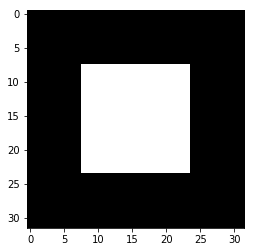

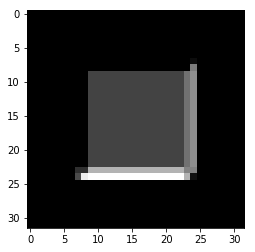

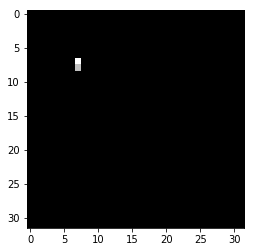

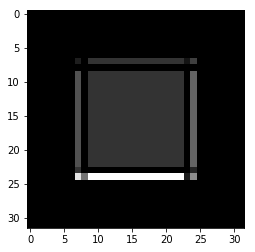

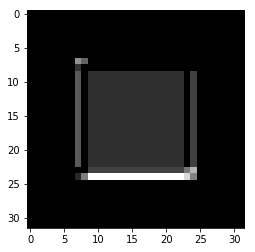

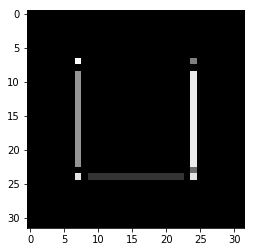

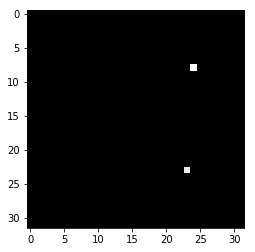

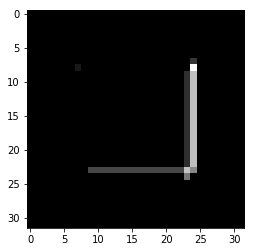

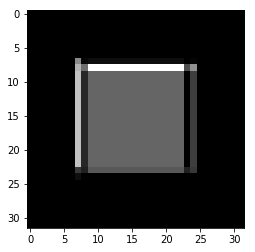

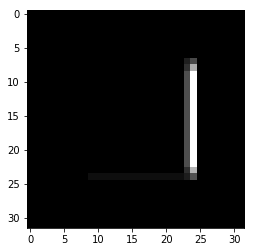

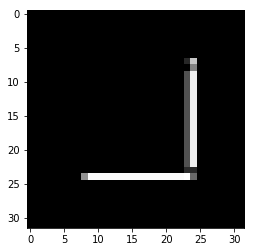

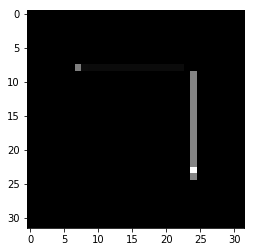

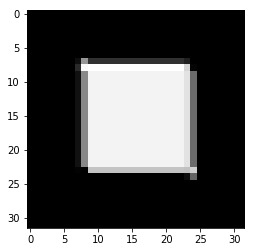

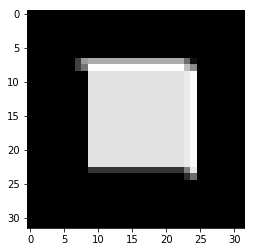

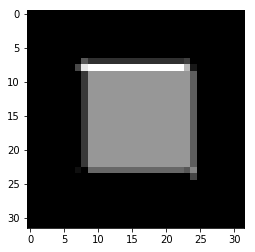

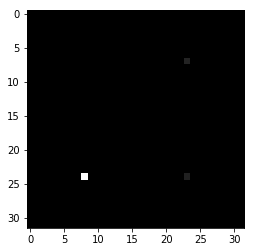

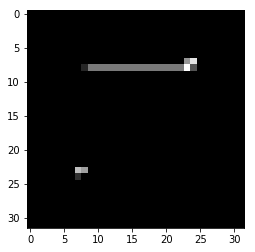

In [6]:
# Now let's visualize the input and the 10 feature maps of the convolution layer.
plt.imshow(inputs[0,:,:,0], cmap='gray')
plt.show()

# Pluck out the 0-th image and then all 16 feature maps, and visualize
# the result.
for i in range(16):
    feature_map = conv_out[0, :, :, i]
    plt.imshow(feature_map, cmap='gray')
    plt.show()

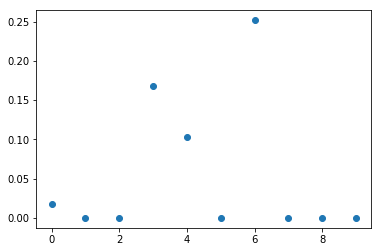

In [7]:
fc_features = fully_out[0, :]
plt.plot(fc_features, 'o')

# Exercise
## Working with Pretrained Slim Models

Here we load a VGG16 model which has already been trained on ImageNet. ImageNet is a large dataset with approximately 1,000,000 images and 1,000 classes, e.g. aeroplanes, cars, types of dogs, etc.

In this exercise you will have to use a pretrained vgg network and apply it to three given images.

In [8]:
# We begin with some preprocessing code to load the ImageNet class names.
# This code is from https://github.com/tensorflow/models/blob/master/slim/datasets/imagenet.py

filename = "data/IMAGENET/predictions_to_labels.txt"
synset_list = [s.strip() for s in open(filename).readlines()]
num_synsets_in_ilsvrc = len(synset_list)
assert num_synsets_in_ilsvrc == 1000

filename = "data/IMAGENET/labels_to_human.txt"
synset_to_human_list = open(filename).readlines()
num_synsets_in_all_imagenet = len(synset_to_human_list)
assert num_synsets_in_all_imagenet == 21842

synset_to_human = {}
for s in synset_to_human_list:
    parts = s.strip().split('\t')
    assert len(parts) == 2
    synset = parts[0]
    human = parts[1]
    synset_to_human[synset] = human

label_index = 0
labels_to_names = dict()

for synset in synset_list:
    name = synset_to_human[synset]
    labels_to_names[label_index] = name
    label_index += 1

In [9]:
import tensorflow as tf
from tensorflow.contrib.layers import conv2d, fully_connected, max_pool2d, repeat
from scipy import misc
slim = tf.contrib.slim

# Network definition copied from https://github.com/tensorflow/models/blob/master/slim/nets/vgg.py
def vgg_16(inputs, num_classes=1000, scope='vgg_16'):
    
    with tf.variable_scope(scope, 'vgg_16', [inputs]) as sc:
        
        with slim.arg_scope([conv2d, fully_connected, max_pool2d]):
            net = repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = max_pool2d(net, [2, 2], scope='pool1')
            net = repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net = max_pool2d(net, [2, 2], scope='pool2')
            net = repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
            net = max_pool2d(net, [2, 2], scope='pool3')
            net = repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
            net = max_pool2d(net, [2, 2], scope='pool4')
            net = repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
            net = max_pool2d(net, [2, 2], scope='pool5')
            # Use conv2d instead of fully_connected layers.
            net = conv2d(net, 4096, [7, 7], padding='VALID', scope='fc6')
            net = conv2d(net, 4096, [1, 1], scope='fc7')
            net = conv2d(net, num_classes, [1, 1], activation_fn=None, normalizer_fn=None, scope='fc8')
            
            return net

In [10]:
# Create the placeholder for the inputs. Note that the input shape for vgg is 224 x 224 x 3 (in classification mode)
inputs = tf.placeholder(dtype=tf.float32,shape=(1,224,224,3))


# Build the network (It requires inputs and number of output classes) 
vgg = vgg_16(inputs)


# Transform logits to probabilities
probs = tf.nn.softmax(vgg)

In [33]:
# Load 3 images
imgsDir = 'images/'
imgsType='.jpg'
imgsNames = ['fly','car','jet']
imgs = [misc.imresize(misc.imread(imgsDir+imgName+imgsType),size=[224,224]).reshape([1,224,224,3]) for imgName in imgsNames ]
# imgFly = misc.imread('images/fly.jpg')
# imgFly = misc.imresize(imgFly,size=[224,224])
# imgCar = misc.imread('images/car.jpg')
# imgCar = misc.imresize(imgCar,size=[224,224])
# imgJet = misc.imread('images/jet.jpg')
# imgJet = misc.imresize(imgJet,size=[224,224])

#print(img.shape)    # (32, 32, 3)

#img_tf = tf.Variable(img)
#print(img_tf.get_shape().as_list())  # [32, 32, 3]

# plt.imshow(imgFly)
# plt.show()

# plt.imshow(imgCar)
# plt.show()

# plt.imshow(imgJet)
# plt.show()


In [28]:
# Create the initialization function for the variables of the network
init_op = tf.global_variables_initializer()
session.run(init_op)

# Define an operator to load model variables from a checkpoint using Slim.
# The checkpoint can be found at https://github.com/tensorflow/models/tree/master/slim

# TODO restore the saved checkpoints ./checkpoints/model.ckpt

# Assuming than 'conv1/weights' should be restored from 'vgg16/conv1/weights'

from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
#print_tensors_in_checkpoint_file(file_name='checkpoints/vgg_16.ckpt', tensor_name='', all_tensors='')

#tvars =tf.trainable_variables()
#print(tvars)

def name_in_checkpoint(var):
  if var.name.startswith('vgg'):
    return var.name.split(':')[0]
  return 'vgg_16/' + var.name.split(':')[0]


variables_to_restore = slim.get_model_variables()
variables_to_restore = {name_in_checkpoint(var):var for var in variables_to_restore}

cleaned = dict()

for var in slim.get_model_variables():
 
  if var.op.name.startswith('fully_connected') or var.op.name.startswith('Conv') :
    continue
  cleaned[name_in_checkpoint(var)]=var

print(cleaned)

restorer = tf.train.Saver(cleaned)

with tf.Session() as sess:
  # Restore variables from disk.
  restorer.restore(session, "checkpoints/vgg_16.ckpt")






{'vgg_16/fc7/weights': <tf.Variable 'vgg_16/fc7/weights:0' shape=(1, 1, 4096, 4096) dtype=float32_ref>, 'vgg_16/conv3/conv3_1/weights': <tf.Variable 'vgg_16/conv3/conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>, 'vgg_16/fc7/biases': <tf.Variable 'vgg_16/fc7/biases:0' shape=(4096,) dtype=float32_ref>, 'vgg_16/conv4/conv4_3/biases': <tf.Variable 'vgg_16/conv4/conv4_3/biases:0' shape=(512,) dtype=float32_ref>, 'vgg_16/conv1/conv1_1/biases': <tf.Variable 'vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>, 'vgg_16/conv4/conv4_3/weights': <tf.Variable 'vgg_16/conv4/conv4_3/weights:0' shape=(3, 3, 512, 512) dtype=float32_ref>, 'vgg_16/conv5/conv5_2/biases': <tf.Variable 'vgg_16/conv5/conv5_2/biases:0' shape=(512,) dtype=float32_ref>, 'vgg_16/conv3/conv3_3/weights': <tf.Variable 'vgg_16/conv3/conv3_3/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>, 'vgg_16/conv1/conv1_1/weights': <tf.Variable 'vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>,

fly: 0.584793
cicada, cicala: 0.200264
dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk: 0.0659519
leafhopper: 0.0348545
lacewing, lacewing fly: 0.0308531


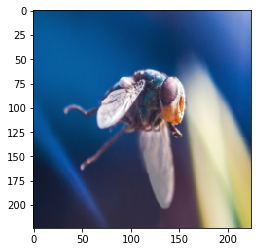

pickup, pickup truck: 0.514543
convertible: 0.0473105
spotlight, spot: 0.0442654
cab, hack, taxi, taxicab: 0.0412512
car wheel: 0.0382764


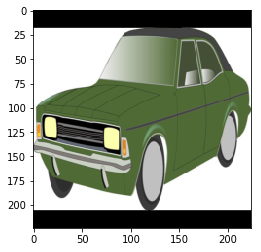

warplane, military plane: 0.842101
wing: 0.148458
airliner: 0.00553041
aircraft carrier, carrier, flattop, attack aircraft carrier: 0.0012709
space shuttle: 0.00123553


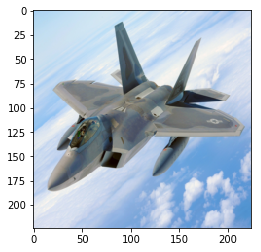

In [38]:
# Start a tensorflow session and run the aforementioned operators
#imgJetReshaped = imgJet.reshape([1,224,224,3])

# #Predict the classes for the given images
for img in imgs:
    probsOut = session.run([probs],feed_dict={inputs:img})
    for idx in ((probsOut[0][0,0,0,:]).argsort()[-5:][::-1]):
        print(labels_to_names[idx]+': '+str(probsOut[0][0,0,0,:][idx]))
    plt.imshow(img[0,:,:,:])
    plt.show()
    




In [ ]:
# Plot the images together with the top-5 classes plus the associated probabilities for these classes
# (hint: sort)

